## Semi-supervised Classification using AutoEncoders

### Introduction
머신러닝은 outcome을 예측하기 위해 사용되는 데이터로부터 가장 가능성 있고 가장 관련 있는 패턴, 관계 연관성을 배우는 복잡한 과정으로 정의된다. 넓게 세 가지 다른 머신러닝 과정이 있다.
1. 지도학습 supervised learning
 - 
2. 비지도학습 unsupervised learning
3. 준지도학습 semi-supervised learning

### Fraud Detection using Semi Supervised Learning
- 다음의 데이터를 이용한다. [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

### Contents
1. Dataset Preparation
2. Visualize Fraud vs Non Fraud Transactions
3. AutoEncoders: Latent Representation Extraction
4. Obtain the Latent Representation
5. Visualize Latent Representations: Fraud vs Non Fraud
6. Simple Linear Classifier
7. Applying the same technique on Titanic Dataset

### 1. Dataset Preparation
- 필요한 라이브러리와 dataset 불러오기.
- Time data에 대한 설명: Number of seconds elapsed between this transaction and the first transaction in the dataset

In [61]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

data=pd.read_csv("C:/Users/Kyungseon/self_study/202207/credit/input/creditcard.csv")
data["Time"]=data["Time"].apply(lambda x:x/3600%24) # %24는 24로 나눈 나머지
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


- 데이터는 28개의 anonymized 변수, 1개의 time, 1개의 amount, 1개의 target 변수로 이루어져 있다.
- 타겟 변수의 분포를 살펴보자.

In [62]:
vc=data['Class'].value_counts().to_frame().reset_index()
#to_frame 새로운 데이터 프레임 생성, 행 인덱스를 0 1 2 .. 으로 초기화

vc['percent']=vc["Class"].apply(lambda x:round(100*float(x)/len(data),2))
#round 반올림, float 실수형 변환
vc=vc.rename(columns={"index":"Target","Class":"Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


- 가장 큰 문제는 이 데이터의 타겟이 매우 불균형하다는 점이다. (0.17%)
- 하지만 representation learning approach는 이러한 불균형을 다룰 수 있다는 장점이 있다.
- 비 이상치 데이터중에서 1000행만 써보자.

In [66]:
non_fraud=data[data['Class']==0].sample(1000)
#sample 랜덤하게 1000개의 데이터를 뽑자
fraud=data[data['Class']==1]

df=pd.concat([non_fraud,fraud])

print(df)

df=df.sample(frac=1).reset_index(drop=True)
#append 행 추가 sample(frac=랜덤으로 뽑을 비율) reset_index d=T는 인덱스로 지정은 하되 기존 열을 남겨놓는다.

X = df.drop(['Class'], axis = 1).values
#axis=0 은 행 방향으로 동작 axis=1은 열 방향으로 동작
Y = df["Class"].values

print(df.head())

             Time        V1        V2        V3        V4        V5        V6  \
66842   14.511944 -1.598845  1.930668 -0.969972 -2.090836  0.195356  0.289025   
57345   13.296944  1.538369 -0.852124 -0.292327 -1.527227 -0.916123 -0.838509   
79815   16.163611  0.997559 -0.883122  0.614282  0.512120 -1.166801 -0.022270   
79801   16.162778 -0.197598 -0.580029  0.661338 -2.596929  0.968641  3.853334   
175607  10.003056  2.126861 -0.846699 -0.679661 -0.771432 -0.911215 -0.900737   
...           ...       ...       ...       ...       ...       ...       ...   
279863  22.983889 -1.927883  1.125653 -4.518331  1.749293 -1.566487 -2.010494   
280143  23.040833  1.378559  1.289381 -5.004247  1.411850  0.442581 -1.326536   
280149  23.041944 -0.676143  1.126366 -2.213700  0.468308 -1.120541 -0.003346   
281144  23.212778 -3.113832  0.585864 -5.399730  1.817092 -0.840618 -2.943548   
281674  23.318889  1.991976  0.158476 -2.583441  0.408670  1.151147 -0.096695   

              V7        V8 

### 2. Visualize Fraud and NonFraud Transactions
- T-SNE(t-distributed Stochastic Neighbor Embedding)를 이용한 시각화
- 데이터 차원 축소 기술

C:\Users\Kyungseon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Kyungseon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


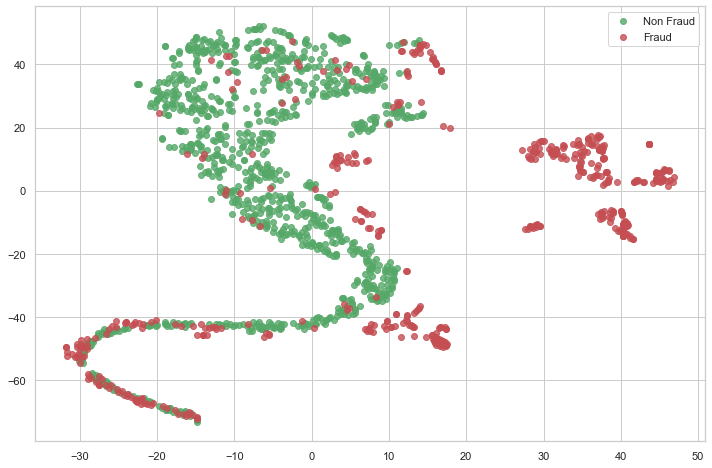

In [67]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

- 위의 그래프에서 보면 사기거래에 가까운 정상 거래가 많기 때문에 모델에서 정확하게 분류하기 어렵다.

### 3. AutoEncoders to the rescue

- 오토 인코더란?
    - output과 input이 동일한 특수 신경망 구조입니다.
    - input의 극히 낮은 수준의 표현을 학습하기 위해 비지도로 훈련됩니다.
    - 낮은 수준의 feature는 실제 데이터를 투영하기 위해 다시 변형됩니다.
    - 네트워크가 input을 예측하는 회귀 모델이다.
    - 병목현상이 심하므로 디코더에서 원래 입력을 재현하는 데에 사용할 수 있는 저차원 코드로 입력을 압축하는 효과적인 표현을 생성해야 한다.
----   
- 정상거래만 표시하는 자동 인코더 모델을 생성하자.
- 모델은 정상거래의 가장 좋은 representation을 배우려고 한다.
- 동일한 모델이 사기 representation을 생성하는 데에도 사용된다.
- 우리는 이 둘이 다를 것이라고 생각한다.

- 동일한 차원을 갖는 하나의 input layer와 output layer로 네트워크를 만들자. 
- keras를 이용한다.


In [68]:
input_layer = Input(shape=(X.shape[1],))

# encoding 
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

# decoding 
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)


output_layer = Dense(X.shape[1], activation='relu')(decoded)

- input layer와 output layer를 엮어서 모델 구조를 만들자.
- optimizer("adadelta")와 loss fuction(mse)을 추가한다.

In [69]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

- model training 전에 min max scaling을 해보자.

In [70]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

- 이 방식의 장점은 좋은 표현을 학습하기 위해 많은 데이터샘플이 필요하지 않다는 것이다.
- 오토인코더를 training하기 위해 2000행의 정상거래만 사용한다.
- 또한 많은 epoch를 실행하지 않아도 된다.
---
- 원본 데이터세트에서 작은 샘플을 선택하는 것은 정상거래 특성이 사기거래 특성과 다를 것이라는 직관을 기반으로 한다.
- 이러한 특성을 구별하려면 오토인코더에 데이터의 한 클래스만 표시해야 한다.
- 이는 오토인코더가 한 클래스만 학습하고 다른 클래스를 자동으로 구분하려고 하기 때문이다.

In [71]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 [==============================] - 1s 30ms/step - loss: 0.2167 - val_loss: 0.2158
Epoch 2/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2164 - val_loss: 0.2154
Epoch 3/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2160 - val_loss: 0.2151
Epoch 4/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2156 - val_loss: 0.2147
Epoch 5/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2153 - val_loss: 0.2143
Epoch 6/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2149 - val_loss: 0.2139
Epoch 7/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2145 - val_loss: 0.2135
Epoch 8/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2141 - val_loss: 0.2132
Epoch 9/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2137 - val_loss: 0.2128
Epoch 10/10
7/7 [==============================] - 0s 5ms/step - loss: 0.2133 - val_loss: 0.2124


### 4. Obtain the Latent Representation
- 모델이 학습되었다. 우리는 모델에 의해 학습된 잠재 표현을 얻고 싶다.
- 훈련된 모델의 가중치로 접근하면 얻을 수 있다.
- 우리는 연속 계측을 포함하는 다른 네트워크를 만들고 잠재 표현이 존재하는 세 번째 layer까지만 가중치를 추가할 것이다.

In [72]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

- 위의 모델을 이용해서 raw input을 예측해서 정상, 사기 두 가지 클래스에 대한 숨겨진 표현을 생성한다.


In [73]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

16/16 [==============================] - 0s 864us/step


### 5.  Visualize the latent representations : Fraud vs Non Fraud

- 우리가 얻은 latent representation을 이용하여 training data set을 만들고 사기와 정상거래 특성을 시각화하자.

C:\Users\Kyungseon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Kyungseon\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


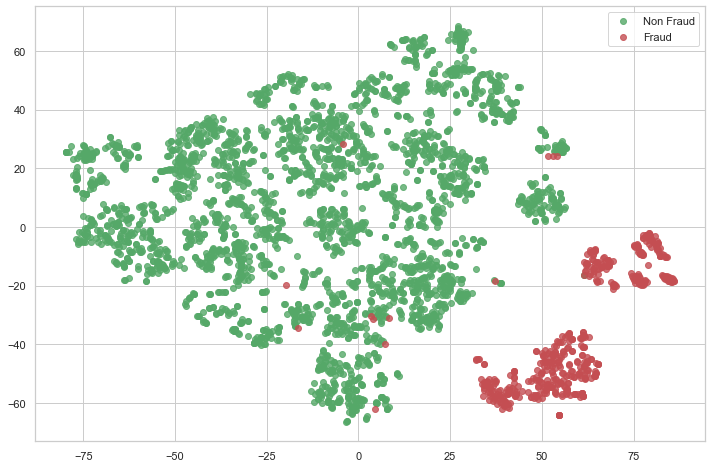

In [74]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

- 정상 거래와 사기 거래가 선형으로 분리 가능하게 보인다.
- 우리는 이것을 분류하기 위해 복잡한 모델이 필요하지 않다.
- 아래는 오토 인코더를 쓰기 전과 후이다.

In [ ]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Actual Representation (Before) </b></td><td><b>Latent Representation (Actual)</b></td></tr>
<tr><td><img src='original.png'></td><td>
             <img src='latent_representation.png'></td></tr></table>"""))

### 6. Simple Linear Classifier

In [77]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("----------------------------------------------------")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("-----------------------------------------------------")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

----------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       744
         1.0       1.00      0.83      0.91       129

    accuracy                           0.97       873
   macro avg       0.99      0.91      0.95       873
weighted avg       0.98      0.97      0.97       873

-----------------------------------------------------
Accuracy Score:  0.9747995418098511


### 코드를 구현하면서 들은 생각

1. 오토인코더는 한가지 특성의 class만 넣어도 자동으로 다른 class를 구분하는 특성이 있다.
 - 그렇다면 정상거래만 넣어도 자동으로 사기거래를 구분할 수 있다는 말.
 - 그런데 이 많은 데이터 안에서 몇개의 사기거래를 어떻게 구분할 수 있는가?

>[코드공유](https://dacon.io/competitions/official/235930/codeshare/5508?page=1&dtype=recent)에 올라온 내용: 
- 30차원의 벡터를 Input으로 하고, AutoEncoder로부터 복구된 30차원의 벡터를 Output으로 하여 Input과 Output 벡터들의 Cosine유사도에 Threshold를 주어 정상/사기로 구별하였습니다.
